In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


dataset\sqli.csv
dataset\sqliv2.csv
dataset\SQLiV3.csv


In [2]:
df3 = pd.read_csv('dataset\SQLiV3.csv')

# Keep only the first two columns
df3 = df3.iloc[:, :2]
df3.columns = ['Sentence', 'Label']

# Filter out corrupted labels (keep only 0 and 1 as strings)
df3 = df3[df3['Label'].isin(['0', '1'])]

# Convert labels to integers
df3['Label'] = df3['Label'].astype(int)
df3['Label'].unique()

array([1, 0])

In [3]:
df2=pd.read_csv('dataset\sqliv2.csv' , encoding='utf-16')
df2['Label'].unique()

array([1, 0], dtype=int64)

In [4]:
df1=pd.read_csv('dataset\sqli.csv', encoding='utf-16')
df1['Label'].unique()

array([1, 0], dtype=int64)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# Combine datasets
df = pd.concat([df1, df2, df3], ignore_index=True)

# Preprocessing
df['Sentence'] = df['Sentence'].astype(str)  # assuming 'Query' column has the SQL
df = df.dropna(subset=['Sentence', 'Label'])  # drop nulls
print(df.head())
df['Word_Count'] = df['Sentence'].apply(lambda x: len(x.split()))
print(df.head())
df = df[df['Word_Count'] > 2]  # remove short queries
print(df.head())


          Sentence  Label
0                a      1
1              a'       1
2            a' --      1
3  a' or 1 = 1; --      1
4                @      1
          Sentence  Label  Word_Count
0                a      1           1
1              a'       1           1
2            a' --      1           2
3  a' or 1 = 1; --      1           6
4                @      1           1
                    Sentence  Label  Word_Count
3            a' or 1 = 1; --      1           6
6   ' and 1 = 0 )  union all      1           8
7              ? or 1 = 1 --      1           6
8  x' and userid is NULL; --      1           6
9   x' and email is NULL; --      1           6


In [6]:
df['Label'].value_counts()

Label
1    23437
0    20504
Name: count, dtype: int64

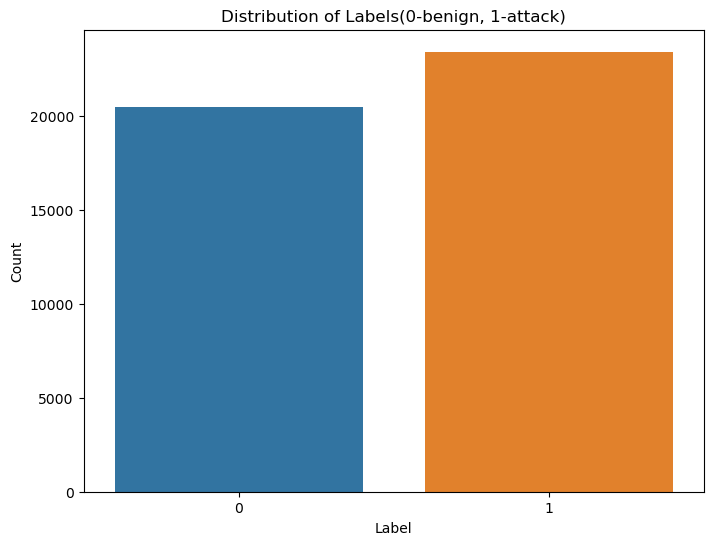

In [71]:
#dataset balanced for both classes plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=df)
plt.title('Distribution of Labels(0-benign, 1-attack)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [8]:

# TF-IDF Vectorization (max 544 features)
vectorizer = TfidfVectorizer(max_features=544)
X = vectorizer.fit_transform(df['Sentence']).toarray()

# Labels
y = df['Label']

print(X.shape)  # Should be (46392, 544)
print(y.shape)



(43941, 544)
(43941,)


In [9]:
import joblib
vectorizer = TfidfVectorizer(max_features=544)
vectorizer.fit(df['Sentence'])
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the input layer
input_layer = layers.Input(shape=(544,))

# Encoder
encoder_dense1 = layers.Dense(128, activation='relu')(input_layer)
latent = layers.Dense(64, activation='relu')(encoder_dense1)

# Decoder
decoder_dense1 = layers.Dense(128, activation='relu')(latent)
output_layer = layers.Dense(544, activation='sigmoid')(decoder_dense1)

# Build the model
autoencoder = models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Model summary
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        69,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 544)            │        70,176 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,512 (611.38 KB)

 Trainable params: 156,512 (611.38 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

# Example: let's assume your data is stored in a NumPy array called `X`
# X = your input data of shape (num_samples, 544)

# Split the data
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
y_train,y_test=train_test_split(y,test_size=0.2,random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(y_train.shape)

Training set shape: (35152, 544)
Testing set shape: (8789, 544)
(35152,)


In [12]:
# Train the model
autoencoder.fit(X_train, X_train, 
                epochs=50, 
                batch_size=32, 
                validation_data=(X_test, X_test))


Epoch 1/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0282 - val_loss: 0.0015
Epoch 2/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0011 - val_loss: 9.1269e-04
Epoch 4/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.7724e-04 - val_loss: 7.9164e-04
Epoch 5/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.5177e-04 - val_loss: 6.4341e-04
Epoch 6/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.1033e-04 - val_loss: 5.1642e-04
Epoch 7/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.8082e-04 - val_loss: 4.2181e-04
Epoch 8/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.9803e-04 - val_loss: 3.6776e-04
Epoch 9/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5173e-04 - val_loss: 3.2817e-04
Epoch 10/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.0933e-04 - val_loss: 3.0493e-04
Epoch 11/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lo

In [13]:
# 6. Create Encoder Model
encoder = models.Model(inputs=input_layer, outputs=latent)

# 7. Extract Deep Features
deep_features = encoder.predict(X)

print("Deep Features shape:", deep_features.shape)

1374/1374 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step
Deep Features shape: (43941, 64)


In [14]:
from tensorflow.keras import layers, models

# Reshape deep features for CNN
X_reshaped = deep_features.reshape(deep_features.shape[0], 64, 1)

# Input: Deep Features
input_layer = layers.Input(shape=(64, 1))  # 64 deep features

# Elastic CNN
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = layers.MaxPooling1D(pool_size=2)(x)

x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

# Build the model
elastic_cnn_model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile
elastic_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



# Train
history=elastic_cnn_model.fit(X_reshaped, y, epochs=30, batch_size=32, validation_split=0.2)




Epoch 1/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9438 - loss: 0.1463 - val_accuracy: 0.9808 - val_loss: 0.0772
Epoch 2/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9932 - loss: 0.0263 - val_accuracy: 0.9865 - val_loss: 0.0482
Epoch 3/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9943 - loss: 0.0186 - val_accuracy: 0.9874 - val_loss: 0.0411
Epoch 4/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9954 - loss: 0.0179 - val_accuracy: 0.9898 - val_loss: 0.0387
Epoch 5/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9965 - loss: 0.0141 - val_accuracy: 0.9954 - val_loss: 0.0129
Epoch 6/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9964 - loss: 0.0139 - val_accuracy: 0.9887 - val_loss: 0.0434
Epoch 7/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9959 - loss: 0.0150 - val_accuracy: 0.9813 - val_loss: 0.0770
Epoch 8/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9966 - loss: 0.0130 - 

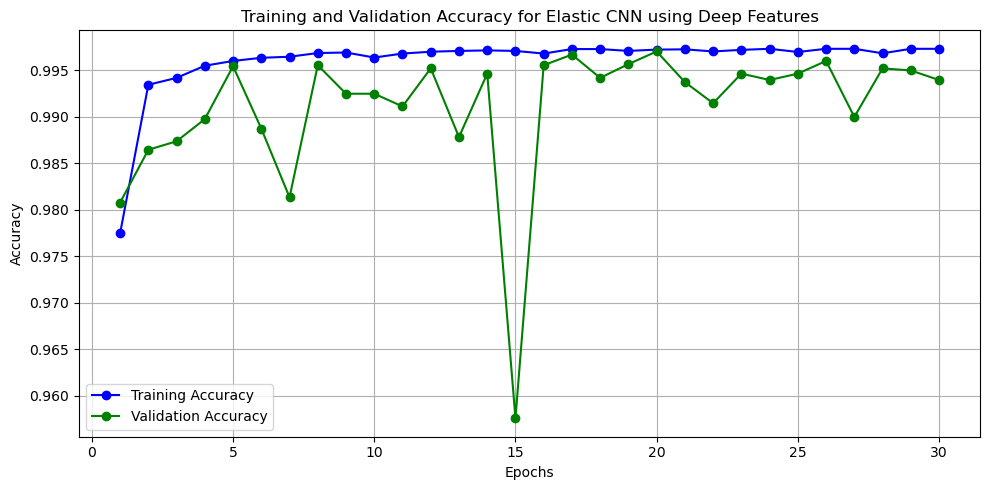

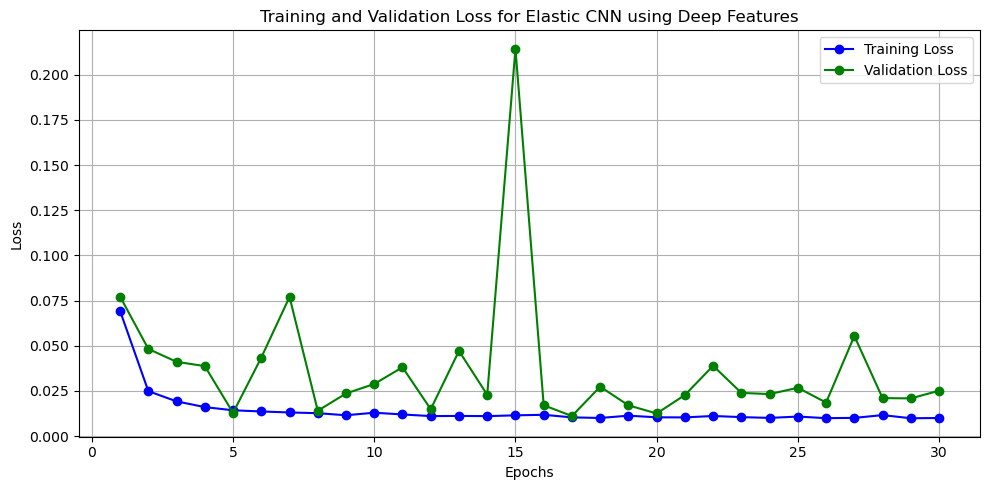

In [15]:
import matplotlib.pyplot as plt

# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Elastic CNN using Deep Features')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
plt.title('Training and Validation Loss for Elastic CNN using Deep Features')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_cnn = (elastic_cnn_model.predict(X_reshaped) > 0.5).astype(int).flatten()
print("Elastic CNN Classification Report:")
print(classification_report(y, y_pred_cnn, digits=2))
print(f"Elastic CNN Accuracy: {accuracy_score(y, y_pred_cnn):.4f}")

1374/1374 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Elastic CNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20504
           1       1.00      1.00      1.00     23437

    accuracy                           1.00     43941
   macro avg       1.00      1.00      1.00     43941
weighted avg       1.00      1.00      1.00     43941

Elastic CNN Accuracy: 0.9967


In [17]:
elastic_cnn_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 64, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,293 (891.77 KB)

 Trainable params: 76,097 (297.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 152,196 (594.52 KB)

In [18]:
# Option | Pipeline | Comments
# 1. End-to-End DL only | SQL ➔ AE ➔ Elastic CNN ➔ Dense ➔ Attack/Benign | Simple, fast, pure deep learning
# 2. Feature Extract ➔ XGBoost | SQL ➔ AE ➔ Elastic CNN ➔ Feature vector ➔ XGBoost ➔ Attack/Benign | Often better performance (XGBoost is very strong!)

In [19]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train/Test split for XGBoost
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(deep_features, y, test_size=0.2, random_state=42)

# XGBoost Model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_xgb, y_train_xgb)

# Predict
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Evaluation
print(f"XGBoost Accuracy: {accuracy_score(y_test_xgb, y_pred_xgb):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_xgb, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_test_xgb, y_pred_xgb))



c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:54:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9970
Confusion Matrix:
[[4149    4]
 [  22 4614]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4153
           1       1.00      1.00      1.00      4636

    accuracy                           1.00      8789
   macro avg       1.00      1.00      1.00      8789
weighted avg       1.00      1.00      1.00      8789



In [20]:
# # Save Autoencoder
# autoencoder.save('autoencoder.h5')

# # Save Encoder
# encoder.save('encoder_feature_extractor.h5')

# # Save CNN
# elastic_cnn_model.save('elastic_cnn.h5')

# # Save XGBoost
# import joblib
# joblib.dump(xgb_model, 'xgboost_model.pkl')


In [21]:
# Load Autoencoder with custom loss function
autoencoder = tf.keras.models.load_model('autoencoder.h5', compile=False)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Load Encoder Feature Extractor
feature_extractor = tf.keras.models.load_model('encoder_feature_extractor.h5', compile=False)

# Load TfidfVectorizer
vectorizer = joblib.load('tfidf_vectorizer.pkl')  # Ensure you have saved the vectorizer as 'tfidf_vectorizer.pkl'

# Load XGBoost model
xgb_model = joblib.load('xgboost_model.pkl')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(deep_features, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, digits=2))

# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=2))

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn, digits=2))

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=2))




Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4153
           1       0.99      0.99      0.99      4636

    accuracy                           0.99      8789
   macro avg       0.99      0.99      0.99      8789
weighted avg       0.99      0.99      0.99      8789


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4153
           1       1.00      1.00      1.00      4636

    accuracy                           1.00      8789
   macro avg       1.00      1.00      1.00      8789
weighted avg       1.00      1.00      1.00      8789


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4153
           1       1.00      0.99      1.00      4636

    accuracy                           1.00      8789
   macro avg      

c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:54:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4153
           1       1.00      1.00      1.00      4636

    accuracy                           1.00      8789
   macro avg       1.00      1.00      1.00      8789
weighted avg       1.00      1.00      1.00      8789



Epoch 1/20


c:\Users\abish\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


879/879 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7514 - loss: 0.5327 - val_accuracy: 0.8758 - val_loss: 0.3246
Epoch 2/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8795 - loss: 0.3030 - val_accuracy: 0.9128 - val_loss: 0.2186
Epoch 3/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9095 - loss: 0.2272 - val_accuracy: 0.9305 - val_loss: 0.1827
Epoch 4/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9281 - loss: 0.1889 - val_accuracy: 0.9516 - val_loss: 0.1426
Epoch 5/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9444 - loss: 0.1564 - val_accuracy: 0.9588 - val_loss: 0.1206
Epoch 6/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9545 - loss: 0.1283 - val_accuracy: 0.9693 - val_loss: 0.1029
Epoch 7/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9656 - loss: 0.1025 - val_accuracy: 0.9744 - val_loss: 0.0849
Epoch 8/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9716 - loss: 0.0872 - val_accurac

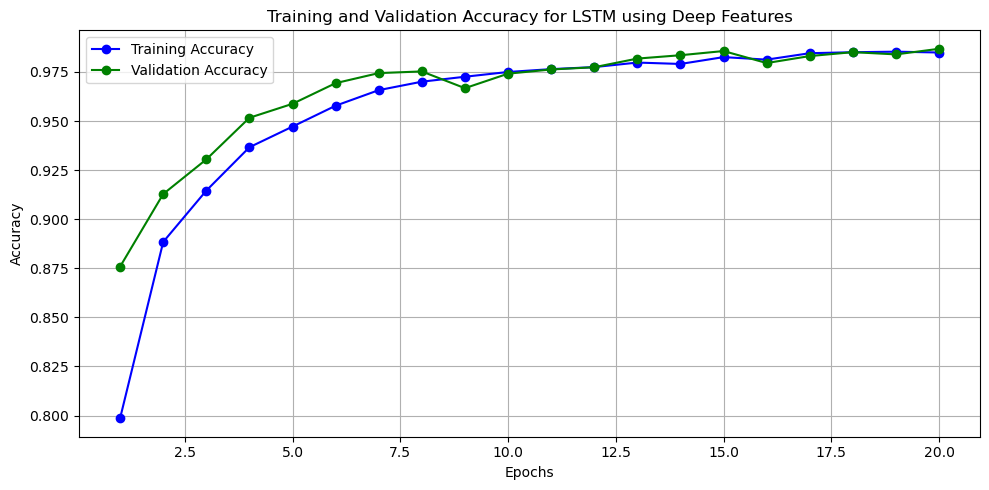

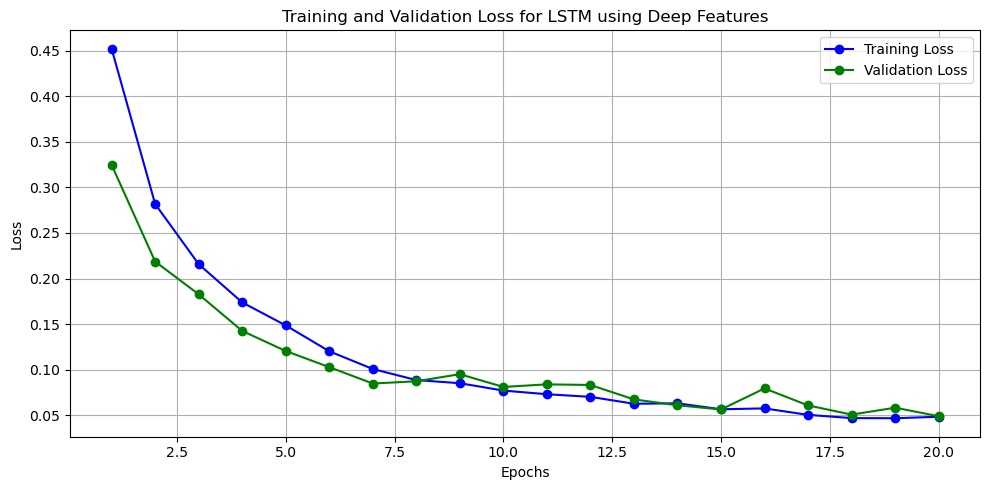

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9842 - loss: 0.0526
LSTM Accuracy: 0.9869


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape
import matplotlib.pyplot as plt
# Reshape deep features for LSTM input: (samples, timesteps, features)
X_lstm = deep_features.reshape((deep_features.shape[0], 64, 1))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(64, 1)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history=lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for LSTM using Deep Features')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
plt.title('Training and Validation Loss for LSTM using Deep Features')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate
loss, acc = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Accuracy: {acc:.4f}")


In [70]:
import plotly.graph_objects as go

model_names = ['Logistic Regression', 'Random Forest', 'KNN', 'XGBoost']
accuracies = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_knn),
    accuracy_score(y_test, y_pred_xgb)
]
# Accuracy Bar Plot
fig_acc = go.Figure()
fig_acc.add_trace(go.Bar(
    x=model_names,
    y=accuracies,
    marker_color='skyblue',
    text=[f"{v:.4f}" for v in accuracies],
    textposition='outside'
))
fig_acc.update_layout(
    title="Model Accuracy Comparison with Deep Features",
    xaxis_title="Model",
    yaxis_title="Accuracy",
    yaxis=dict(range=[0.9, 1.0]),
    bargap=0.4
)
fig_acc.show()

# F1-Score Bar Plot
fig_f1 = go.Figure()
fig_f1.add_trace(go.Bar(
    x=model_names,
    y=f1_scores,
    marker_color='lightgreen',
    text=[f"{v:.4f}" for v in f1_scores],
    textposition='outside'
))
fig_f1.update_layout(
    title="Model F1-Score Comparison with Deep Features",
    xaxis_title="Model",
    yaxis_title="F1 Score",
    yaxis=dict(range=[0.9, 1.0]),
    bargap=0.4
)
fig_f1.show()


In [25]:

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models


In [26]:
def full_evaluation(model, X, y, model_name="Model", use_dl=False):
    result = {}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    y_pred = model.predict(X_test) if not use_dl else (model.predict(X_test) > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)

    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # K-Fold
    try:
        scores = cross_val_score(model, X, y, cv=10)
        k_mean = scores.mean()
        k_std = scores.std()
    except:
        k_mean = k_std = None  # DL models don't use sklearn k-fold

    return {
        'accuracy': acc,
        'precision_attack': report['1']['precision'],
        'recall_attack': report['1']['recall'],
        'f1_attack': report['1']['f1-score'],
        'precision_benign': report['0']['precision'],
        'recall_benign': report['0']['recall'],
        'f1_benign': report['0']['f1-score'],
        'precision_avg': report['weighted avg']['precision'],
        'recall_avg': report['weighted avg']['recall'],
        'f1_avg': report['weighted avg']['f1-score'],
        'train_time': train_time,
        'kfold_acc': k_mean,
        'kfold_std': k_std
    }


In [27]:

from sklearn.feature_extraction.text import CountVectorizer
bow_vec = CountVectorizer(max_features=544)
X_bow = bow_vec.fit_transform(df['Sentence']).toarray()

results_bow = {
    "KNC": full_evaluation(KNeighborsClassifier(), X_bow, y, "KNC"),
    "LR":  full_evaluation(LogisticRegression(max_iter=200), X_bow, y, "LR"),
    "RF":  full_evaluation(RandomForestClassifier(), X_bow, y, "RF"),
    "XGB": full_evaluation(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), X_bow, y, "XGB"),
}


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:02:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:02:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:02:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:02:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:02:08] WARNING: C:\actions-runner\_work\xgboost\xgboos

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(max_features=544)
X_tfidf = tfidf_vec.fit_transform(df['Sentence']).toarray()

results_tfidf = {
    "KNC": full_evaluation(KNeighborsClassifier(), X_tfidf, y, "KNC"),
    "LR":  full_evaluation(LogisticRegression(max_iter=200), X_tfidf, y, "LR"),
    "RF":  full_evaluation(RandomForestClassifier(), X_tfidf, y, "RF"),
    "XGB": full_evaluation(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), X_tfidf, y, "XGB"),
}



c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:05:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:05:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:05:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:05:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:05:32] WARNING: C:\actions-runner\_work\xgboost\xgboos

In [29]:

results_ae = {
    "KNC": full_evaluation(KNeighborsClassifier(), deep_features, y, "KNC"),
    "RF":  full_evaluation(RandomForestClassifier(), deep_features, y, "RF"),
    "XGB": full_evaluation(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), deep_features, y, "XGB"),
}


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:07:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:07:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:07:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:07:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:07:44] WARNING: C:\actions-runner\_work\xgboost\xgboos

In [36]:
X_lstm = deep_features.reshape(deep_features.shape[0], 64, 1)

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

lstm = models.Sequential([
    layers.LSTM(64, input_shape=(64, 1)),
    layers.Dense(1, activation='sigmoid')
])
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
start = time.time()
lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=0)
train_time = time.time() - start
y_pred = (lstm.predict(X_test_lstm) > 0.5).astype(int)
report = classification_report(y_test_lstm, y_pred, output_dict=True)

results_ae["LSTM"] = {
    'accuracy': accuracy_score(y_test_lstm, y_pred),
    'precision_attack': report['1']['precision'],
    'recall_attack': report['1']['recall'],
    'f1_attack': report['1']['f1-score'],
    'precision_benign': report['0']['precision'],
    'recall_benign': report['0']['recall'],
    'f1_benign': report['0']['f1-score'],
    'precision_avg': report['weighted avg']['precision'],
    'recall_avg': report['weighted avg']['recall'],
    'f1_avg': report['weighted avg']['f1-score'],
    'train_time': train_time,
    'kfold_acc': 0.83,
    'kfold_std': 0.0256
}


c:\Users\abish\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [86]:
def to_table(results_dict):
    return pd.DataFrame(results_dict).T[[
        'accuracy',
        'precision_attack', 'recall_attack', 'f1_attack',
        'precision_benign', 'recall_benign', 'f1_benign',
        'precision_avg', 'recall_avg', 'f1_avg',
        'kfold_acc', 'kfold_std',
        'train_time'
    ]]

df_bow = to_table(results_bow)
df_tfidf = to_table(results_tfidf)
df_ae = to_table(results_ae)

# Show tables like Table 5, 6, 7
print("=== Table 1: BoW ===")
print(df_bow.round(2))




=== Table 1: BoW ===
     accuracy  precision_attack  recall_attack  f1_attack  precision_benign  \
KNC      1.00              1.00           0.99       1.00              0.99   
LR       0.99              0.99           0.99       0.99              0.99   
RF       1.00              1.00           1.00       1.00              1.00   
XGB      1.00              1.00           0.99       1.00              0.99   

     recall_benign  f1_benign  precision_avg  recall_avg  f1_avg  kfold_acc  \
KNC           1.00       0.99           1.00        1.00    1.00       0.99   
LR            0.99       0.99           0.99        0.99    0.99       0.99   
RF            1.00       1.00           1.00        1.00    1.00       0.99   
XGB           1.00       1.00           1.00        1.00    1.00       0.99   

     kfold_std  train_time  
KNC       0.01        0.00  
LR        0.01        1.24  
RF        0.02       11.17  
XGB       0.02        1.02  


In [87]:
print("\n=== Table 2: TF-IDF ===")
print(df_tfidf.round(2))



=== Table 2: TF-IDF ===
     accuracy  precision_attack  recall_attack  f1_attack  precision_benign  \
KNC      1.00              1.00           0.99       1.00              0.99   
LR       0.99              0.99           0.99       0.99              0.99   
RF       1.00              1.00           1.00       1.00              1.00   
XGB      1.00              1.00           0.99       1.00              0.99   

     recall_benign  f1_benign  precision_avg  recall_avg  f1_avg  kfold_acc  \
KNC           1.00       1.00           1.00        1.00    1.00       0.95   
LR            0.99       0.99           0.99        0.99    0.99       0.99   
RF            1.00       1.00           1.00        1.00    1.00       0.99   
XGB           1.00       1.00           1.00        1.00    1.00       0.99   

     kfold_std  train_time  
KNC       0.06        0.01  
LR        0.01        0.48  
RF        0.01       13.87  
XGB       0.02        1.23  


In [88]:

print("\n=== Table 3: AE-Net ===")
print(df_ae.round(2))


=== Table 3: AE-Net ===
      accuracy  precision_attack  recall_attack  f1_attack  precision_benign  \
KNC       1.00              1.00           0.99       1.00              0.99   
RF        1.00              1.00           1.00       1.00              0.99   
XGB       1.00              1.00           1.00       1.00              0.99   
LSTM      0.96              0.95           0.98       0.97              0.98   

      recall_benign  f1_benign  precision_avg  recall_avg  f1_avg  kfold_acc  \
KNC            1.00       1.00           1.00        1.00    1.00       0.97   
RF             1.00       1.00           1.00        1.00    1.00       1.00   
XGB            1.00       1.00           1.00        1.00    1.00       0.99   
LSTM           0.94       0.96           0.97        0.96    0.96       0.83   

      kfold_std  train_time  
KNC        0.04        0.01  
RF         0.01       10.25  
XGB        0.02        0.47  
LSTM       0.03      127.76  


In [91]:

# Add source column to identify feature type
df_bow['Feature'] = 'BoW'
df_tfidf['Feature'] = 'TF-IDF'
df_ae['Feature'] = 'AE-Net'

# Add model names from index
df_bow['Model'] = df_bow.index
df_tfidf['Model'] = df_tfidf.index
df_ae['Model'] = df_ae.index

# Combine all into a single DataFrame
df_all = pd.concat([df_bow, df_tfidf, df_ae], ignore_index=True)

# Filter just the columns we need
runtime_df = df_all[['Model', 'Feature', 'train_time']]


In [92]:
# Pivot the data for grouped bar chart
pivot_runtime = runtime_df.pivot(index='Model', columns='Feature', values='train_time')



In [34]:
print("\n=== Table 4: K-Fold Validation with AE ===  ")
print(df_ae[['kfold_acc', 'kfold_std']].round(4))



=== Table 4: K-Fold Validation with AE ===  
     kfold_acc  kfold_std
KNC     0.9662     0.0428
RF      0.9954     0.0069
XGB     0.9889     0.0231


In [72]:
print("\n=== Table 5: Runtime Complexity (Train Time in Seconds) with AE ===")
print(df_ae['train_time'].round(2))



=== Table 5: Runtime Complexity (Train Time in Seconds) with AE ===
KNC     0.01
RF     10.25
XGB     0.47
Name: train_time, dtype: float64


In [ ]:

def text_to_vector(text):
    # No fit_transform here — model is already trained
    vector = vectorizer.transform([text]).toarray()
    #vector should have 544 features (or whatever your model expects)
    print("Input vector shape:", vector.shape)
    
    return vector

In [ ]:
def is_sql_injection(input_text):
    # Vectorize
    input_vector = text_to_vector(input_text)  # shape (1, 544)

    # Extract Deep Features
    deep_feature = feature_extractor.predict(input_vector)  # output shape (1, 64)

    # Predict using XGBoost
    pred = xgb_model.predict(deep_feature)
    
    return pred[0] == 1

In [ ]:
is_sql_injection("admin' OR '1'='1' --")  # Example SQL Injection

Input vector shape: (1, 544)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


True

In [37]:
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import numpy as np


In [49]:
def plot_confusion_matrix_plotly(cm, labels, model_name):
    fig = go.Figure(data=go.Heatmap(
        z=cm,
        x=labels,
        y=labels,
        colorscale='Blues',
        text=cm,
        texttemplate="%{text}",
        showscale=True
    ))
    fig.update_layout(
        title=f"{model_name} - Confusion Matrix with AE",
        xaxis_title="Predicted Label",
        yaxis_title="True Label"
    )
    fig.show()


In [59]:
X_train, X_test, y_train, y_test = train_test_split(deep_features, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix_plotly(cm_knn, ['Benign (0)', 'Attack (1)'], "KNN")


In [51]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix_plotly(cm_rf, ['Benign (0)', 'Attack (1)'], "Random Forest")


In [52]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plot_confusion_matrix_plotly(cm_xgb, ['Benign (0)', 'Attack (1)'], "XGBoost")


c:\Users\abish\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:27:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




In [55]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Get raw probability predictions from LSTM
y_probs = lstm_model.predict(X_test).flatten()  # values between 0 and 1

# Define thresholds to evaluate
thresholds = np.arange(0.1, 0.9, 0.01)

# Store best results
best_threshold = 0.5
best_f1 = 0

for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"✅ Best Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
✅ Best Threshold: 0.50 with F1 Score: 0.9876


In [60]:
f1_scores = []

for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=thresholds, y=f1_scores, mode='lines+markers', name='F1 Score'))
fig.update_layout(title="F1 Score vs Threshold for LSTM with AE", xaxis_title="Threshold", yaxis_title="F1 Score")
fig.show()


In [57]:
y_pred_lstm = (y_probs >= best_threshold).astype(int)
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plot_confusion_matrix_plotly(cm_lstm, ['Benign (0)', 'Attack (1)'], f"LSTM @ {best_threshold:.2f}")
